In [1]:
import pandas as pd
import numpy as np

In [2]:
import os 


In [3]:
raw_data_list = []
for r,d,fs in os.walk('../data/csmar_close'):
    for f in fs:
        
        if (not ('[DES]' in f)) and ('txt' in f):
            file_path = os.path.join(r,f)
            # print(file_path)
            raw_data_list.append(pd.read_csv(file_path,
                         sep='\t',
                         dtype={'Stkcd': str}))


In [4]:
working_data  =  pd.concat(raw_data_list,axis=0).set_index(['Trddt','Stkcd'])

In [5]:
working_data.drop_duplicates(inplace=True)


In [6]:
adj_price_df = working_data[['Adjprcwd']].unstack('Stkcd')
adj_price_df.columns = adj_price_df.columns.get_level_values(1)
log_return_df = np.log(adj_price_df.shift(-1)/adj_price_df)

In [7]:
import pandas as pd

def create_monthly_cv(data, step=1, train_size=1, test_size=1):
    """
    基于月份向前推进，创建时间序列数据的训练集和测试集，
    并允许分别指定训练集和测试集的大小，以及-1选项来使用所有可用数据。

    参数:
    data (pd.DataFrame): 带有时间索引的 DataFrame。
    step (int): 每次向前推进的月份数。默认为1个月。
    train_size (int): 每个训练集包含的月份数。
                      如果为 -1，则训练集包含从数据开始到当前测试集开始之前的所有数据。
                      默认为1个月。
    test_size (int): 每个测试集包含的月份数。默认为1个月。

    返回:
    tuple: 包含训练集列表和测试集列表的元组。
    """
    train_list = []
    test_list = []

    # 获取数据的时间范围
    min_date = data.index.min()
    max_date = data.index.max()

    # 确定迭代的起始点
    # 我们需要找到第一个可能的测试集结束日期，这样训练集才不会为空
    # 如果test_size >= 1，那么训练集至少需要是test_size月份的数据
    # 如果train_size = -1，则训练集可以是任意大小，但测试集是关键
    
    # 找到第一个测试集的结束日期
    current_test_end_month = min_date + pd.DateOffset(months=test_size) - pd.Timedelta(days=1)
    
    # 如果第一个测试集结束日期就超过了最大日期，则无法生成任何数据对
    if current_test_end_month > max_date and test_size > 0:
        print("Warning: The specified test_size is too large for the provided data. No data pairs can be generated.")
        return [], []

    # 确立第一个测试集的开始日期
    current_test_start_month = min_date
    
    # 循环生成训练集和测试集对
    while current_test_start_month <= max_date:
        # 计算当前测试集的结束日期
        # 确保不超过数据的最大日期
        current_test_end_month = current_test_start_month + pd.DateOffset(months=test_size) - pd.Timedelta(days=1)
        if current_test_end_month > max_date:
            current_test_end_month = max_date

        # 确定训练集的结束日期
        # 训练集结束于当前测试集开始之前
        train_end_date = current_test_start_month - pd.Timedelta(days=1)

        # 确定训练集的开始日期
        if train_size == -1:
            # 如果 train_size 为 -1，训练集从数据的最小日期开始
            train_start_date = min_date
        else:
            # 否则，训练集从当前测试集开始日期向前推 train_size 个月
            train_start_date = current_test_start_month - pd.DateOffset(months=train_size)

        # 提取训练集数据
        # 确保训练集的开始日期不早于数据的最小日期
        if train_start_date < min_date:
            train_start_date = min_date
            
        # 确保训练集和测试集有重叠（即训练集不为空且测试集不为空）
        # 并且训练集的结束日期必须早于测试集的开始日期
        if train_end_date >= train_start_date and current_test_start_month <= current_test_end_month:
            train_data = data[(data.index >= train_start_date) & (data.index <= train_end_date)]
            test_data = data[(data.index >= current_test_start_month) & (data.index <= current_test_end_month)]

            # 只有当训练集和测试集都非空时，才添加到列表中
            if not train_data.empty and not test_data.empty:
                train_list.append(train_data)
                test_list.append(test_data)
        
        # 推进到下一个测试集的开始日期
        # 确保 step > 0 以避免死循环
        if step <= 0:
            print("Error: step must be a positive integer to avoid infinite loop.")
            break
        
        # 记录推进前的日期，用于检测是否发生变化
        prev_test_start_month = current_test_start_month
        current_test_start_month = current_test_start_month + pd.DateOffset(months=step)
        
        # 如果推进后的日期没有改变（例如，月数不足以进位，或者step=0），则强制推进一天以避免死循环
        if current_test_start_month <= prev_test_start_month:
            current_test_start_month += pd.Timedelta(days=1)
            
        # 如果推进后的测试集开始日期已经超过了数据的最大日期，则结束循环
        if current_test_start_month > max_date:
            break

    return train_list, test_list

In [8]:
log_return_df.std().nlargest(20)

Stkcd
301551    0.117464
300362    0.111201
300431    0.101208
920100    0.085951
600701    0.080831
301632    0.080292
603400    0.078748
688615    0.078213
600891    0.078153
002711    0.070000
837748    0.068652
833030    0.067232
301618    0.067011
837592    0.066559
002359    0.066191
301678    0.065936
920002    0.065159
001221    0.064014
873693    0.063536
831627    0.063231
dtype: float64

In [9]:
adj_price_df.index = pd.to_datetime(adj_price_df.index)

In [10]:
from scipy.optimize import minimize

def min_variance_portfolio_no_short(cov_matrix):
    n = cov_matrix.shape[0]
    
    # 目标函数：组合方差
    def objective(w):
        return w @ cov_matrix @ w
    
    # 约束条件：权重之和为1
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    
    # 边界条件：权重非负
    bounds = [(0, 0.1) for _ in range(n)]
    
    # 初始猜测（等权重）
    w0 = np.ones(n) / n
    
    # 优化
    result = minimize(objective, w0, method='SLSQP', 
                      bounds=bounds, 
                      constraints=constraints,
                      options={'maxiter': 1000, 'ftol': 1e-12}
                     )
    
    return result.x

In [11]:
def train_eval_cv(train_list,test_list,stock_num = 30):
    ret_list = []
    for train,test in zip(train_list,test_list):
        log_ret_train = np.log(train.shift(-1)/train).iloc[:-1]
        log_ret_train  = log_ret_train.T.dropna().T
        
        select = log_ret_train.std().nsmallest(stock_num)
        # selcet = log_ret_train.samlpe(30)
        select_stock = select.index.tolist()
        test.ffill(inplace=True)
        
        select_rets = np.log(test[select_stock].iloc[-1]/test[select_stock].iloc[0])
        is_select_rets = np.log(train[select_stock].iloc[-1]/train[select_stock].iloc[0])
        ret = np.nansum(select_rets)/stock_num
        is_ret =  np.nansum(is_select_rets)/stock_num
    
        # display(log_ret_train[select_stock].tail())
        
        cov_ret = log_ret_train[select_stock].cov()
        # print(log_ret_train.shape)
        mak_weight = min_variance_portfolio_no_short(cov_ret)
        mak_ret = np.sum(mak_weight*select_rets)
        is_mak_ret = np.sum(mak_weight*is_select_rets)
    
        ret_list.append({
            'simple_train':is_ret,
            'mak_train':is_mak_ret,
            'simple_test':ret,
            'mak_test':mak_ret,
        }
        )
    
    return ret_list

In [12]:
working_data.memory_usage().sum()/1024/1024

np.float64(1050.5696830749512)

In [13]:
train_list , test_list = create_monthly_cv(adj_price_df,step=2,train_size=12,test_size=2)
result = train_eval_cv(train_list , test_list) 

/var/folders/qb/_zmdxt6n29n5h6hxbt7v0v0c0000gn/T/ipykernel_4389/2546015914.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.ffill(inplace=True)
/var/folders/qb/_zmdxt6n29n5h6hxbt7v0v0c0000gn/T/ipykernel_4389/2546015914.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.ffill(inplace=True)
/var/folders/qb/_zmdxt6n29n5h6hxbt7v0v0c0000gn/T/ipykernel_4389/2546015914.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.

In [14]:
result = pd.DataFrame(result)
result.mean()/result.std()

simple_train   -0.019734
mak_train       0.216784
simple_test     0.241834
mak_test        0.296274
dtype: float64

<Axes: >

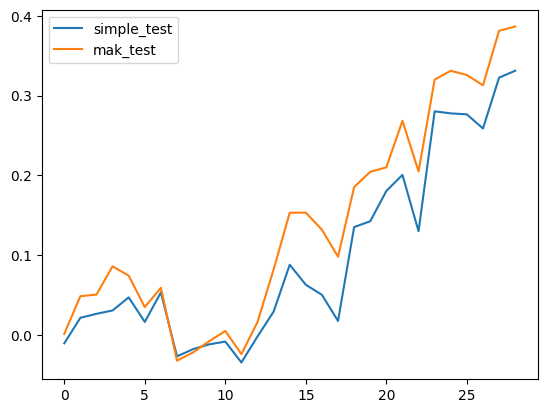

In [15]:
result[['simple_test','mak_test']].cumsum().plot()

<Axes: >

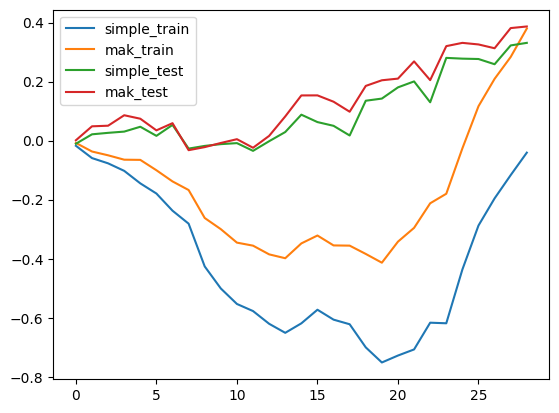

In [16]:
result.cumsum().plot()

In [17]:
#接下来对窗口，开始时间，还有因子数做超参优化

In [18]:
# how past can tell future


In [19]:
test_arr1,test_arr2 = np.random.randn(500),np.random.randn(500)

In [20]:
import numpy as np
from scipy.stats import entropy

def kl_div_core(test_arr1, test_arr2, bins=50, epsilon=1e-10):
    """
    计算两个数组之间KL散度的核心函数
    
    参数:
    test_arr1: 第一个数组（作为真实分布P）
    test_arr2: 第二个数组（作为近似分布Q）
    bins: 直方图的bin数量
    epsilon: 平滑参数，避免除零错误
    
    返回:
    kl_value: KL散度值 D_KL(P || Q)，如果无效数据过多则返回 np.nan
    """
    # 确保输入是numpy数组
    arr1 = np.array(test_arr1)
    arr2 = np.array(test_arr2)

    # print('arr1 NaNs:', np.sum(~np.isfinite(arr1)), 'arr2 NaNs:', np.sum(~np.isfinite(arr2)))
    
    # 选项1: 过滤 NaN（推荐，明确处理）
    arr1_finite = arr1[np.isfinite(arr1)]
    arr2_finite = arr2[np.isfinite(arr2)]
    
    if len(arr1_finite) <= 100 or len(arr2_finite) <= 100:
        # print("Warning: 至少一个数组无有效值，返回 NaN")
        return np.nan
    
    # 计算范围（用过滤后的值）
    min_val = min(np.min(arr1_finite), np.min(arr2_finite))
    max_val = max(np.max(arr1_finite), np.max(arr2_finite))
    
    # 选项2: 或者用 np.nanmin/np.nanmax 简化（无需过滤，但需检查 hist 非空）
    # min_val = min(np.nanmin(arr1), np.nanmin(arr2))
    # max_val = max(np.nanmax(arr1), np.nanmax(arr2))
    
    # 创建概率直方图
    hist1, bin_edges = np.histogram(arr1_finite, bins=bins, range=(min_val, max_val), density=True)
    hist2, _ = np.histogram(arr2_finite, bins=bin_edges, density=True)
    
    # 添加平滑避免零概率
    hist1 = hist1 + epsilon
    hist2 = hist2 + epsilon
    
    # 重新归一化
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)
    
    # 计算KL散度
    kl_value = np.sum(hist1 * np.log(hist1 / hist2))
    
    return kl_value

In [21]:
def kl_sr(sr:pd.Series,window:int = 252,gap:int = 20):
    # sr.fillna(inplace= True)
    sr_arr = sr.values
    
    test_arr1,test_arr2 = sr[-2*window-gap:window-gap],sr[window-gap:-gap]
    return kl_div_core(test_arr1,test_arr2)



    

In [22]:
# log_return_df.fillna(-1,inplace=True)
log_return_df

Stkcd,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,920112,920116,920118,920128,920167,920445,920489,920682,920799,920819
Trddt,,,,,,,,,,,,,,,,,,,,,
2020-09-16,0.008384,-0.004622,0.095351,-0.017826,-0.003396,-0.014077,0.000000,0.028554,-0.023642,-0.003529,...,NaN,NaN,NaN,NaN,0.014938,0.000000,0.000000,0.000000,0.008199,0.005401
2020-09-17,0.031608,0.043242,0.000808,0.014286,0.095619,0.006522,0.013245,0.014638,0.011891,0.095471,...,NaN,NaN,NaN,NaN,0.015800,0.007653,0.007273,0.011364,-0.000860,0.000000
2020-09-18,-0.013154,-0.005476,-0.022464,-0.014286,-0.026626,0.006480,-0.009917,0.006583,-0.016687,-0.006448,...,NaN,NaN,NaN,NaN,-0.002706,-0.003819,-0.003630,-0.004246,0.007712,-0.010830
2020-09-21,-0.018454,-0.006196,-0.024672,-0.021819,-0.022473,-0.015185,-0.006667,-0.033359,-0.021872,-0.054846,...,NaN,NaN,NaN,NaN,-0.002714,-0.002554,-0.009744,-0.002841,-0.006852,-0.009116
2020-09-22,0.003846,-0.009018,0.002959,-0.007380,0.035091,-0.009885,0.003339,-0.042973,-0.004926,0.028630,...,NaN,NaN,NaN,NaN,-0.000544,0.001278,-0.002451,0.001421,-0.012541,-0.001833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-09,0.001701,0.000000,0.021812,NaN,0.010681,0.003940,0.007067,-0.019838,-0.002176,0.008753,...,-0.015974,0.015818,0.019438,-0.017211,-0.031047,0.011281,-0.012915,0.001905,-0.002771,0.028605
2025-09-10,0.006774,-0.004383,0.009337,NaN,0.006618,0.000000,0.000000,-0.000911,0.006515,-0.001090,...,0.011536,0.012881,-0.011409,0.018975,0.007615,0.019834,0.012915,0.006638,0.014631,-0.004348
2025-09-11,-0.011031,0.015977,-0.027322,NaN,0.009192,-0.007895,0.010508,0.036693,0.029853,0.006522,...,-0.015570,-0.010427,-0.010837,-0.014197,-0.017700,-0.034362,-0.012019,-0.013321,-0.007892,-0.022027


In [23]:
kl_df = log_return_df.apply(lambda x: (kl_sr(x)))

In [24]:
zero_kl_stks = kl_df.nsmallest(50).index.to_list()

In [25]:
working_data['ChangeRatio'].unstack(level=1)

Stkcd,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,920112,920116,920118,920128,920167,920445,920489,920682,920799,920819
Trddt,,,,,,,,,,,,,,,,,,,,,
2020-09-16,0.005863,0.011482,-0.020897,-0.007018,0.005111,0.000000,0.000000,0.005548,0.043902,-0.013897,...,NaN,NaN,NaN,NaN,-0.002779,0.001282,-0.002427,-0.004267,-0.000866,-0.008945
2020-09-17,0.008420,-0.004612,0.100044,-0.017668,-0.003390,-0.013978,0.000000,0.028966,-0.023364,-0.003523,...,NaN,NaN,NaN,NaN,0.015050,0.000000,0.000000,0.000000,0.008232,0.005415
2020-09-18,0.032113,0.044191,0.000808,0.014388,0.100340,0.006543,0.013333,0.014745,0.011962,0.100177,...,NaN,NaN,NaN,NaN,0.015925,0.007682,0.007299,0.011429,-0.000859,0.000000
2020-09-21,-0.013068,-0.005461,-0.022213,-0.014184,-0.026275,0.006501,-0.009868,0.006605,-0.016548,-0.006427,...,NaN,NaN,NaN,NaN,-0.002703,-0.003812,-0.003623,-0.004237,0.007742,-0.010772
2020-09-22,-0.018285,-0.006177,-0.024370,-0.021583,-0.022222,-0.015070,-0.006645,-0.032808,-0.021635,-0.053369,...,NaN,NaN,NaN,NaN,-0.002710,-0.002551,-0.009697,-0.002837,-0.006829,-0.009074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-09,0.004274,0.014793,-0.016965,NaN,-0.022310,-0.002625,-0.003534,0.000894,-0.006479,-0.002193,...,-0.028086,-0.052915,-0.003145,-0.022152,-0.043844,-0.058015,-0.026282,-0.022367,-0.016329,-0.028200
2025-09-10,0.001702,0.000000,0.022052,NaN,0.010738,0.003947,0.007092,-0.019643,-0.002174,0.008791,...,-0.015847,0.015943,0.019628,-0.017064,-0.030570,0.011345,-0.012832,0.001907,-0.002767,0.029018
2025-09-11,0.006797,-0.004373,0.009381,NaN,0.006640,0.000000,0.000000,-0.000911,0.006536,-0.001089,...,0.011603,0.012964,-0.011344,0.019156,0.007645,0.020032,0.012999,0.006660,0.014739,-0.004338


In [26]:
(~np.isfinite(kl_df)).sum()

np.int64(5711)

In [27]:
# log_return_df[select_list]

In [28]:
## 实验1 在KL散度更低的股票上，预测误差更小


In [29]:
log_return_df.index = pd.to_datetime(log_return_df.index )

In [30]:
## 实验2 KL散度小的股票等权更好

In [31]:
def get_kl_pos(log_return_df,n=50,min_len = 500 ):
    
    kl_pos = np.zeros(log_return_df.shape[1])
    
    if len(log_return_df) < min_len:
        return kl_pos
        
    kl_df = log_return_df.apply(lambda x: (kl_sr(x)))
    select_list = kl_df.nsmallest(n).index
    kl_pos = np.zeros(log_return_df.shape[1])
    kl_cond = log_return_df.iloc[-1].index.isin(select_list)
    nan_cond = np.isfinite(log_return_df.iloc[-2])
    cond = kl_cond & nan_cond
    kl_pos[cond] = 1
    
    
    return kl_pos

# def get_kl_long_pos(log_return_df,n=300,min_len = 500 ):
    
#     kl_pos = np.zeros(log_return_df.shape[1])
    
#     if len(log_return_df) < min_len:
#         return kl_pos
        
#     kl_df = log_return_df.apply(lambda x: (kl_sr(x)))
#     select_list = kl_df.nsmallest(n).index
#     kl_pos = np.zeros(log_return_df.shape[1])
#     kl_cond = log_return_df.iloc[-1].index.isin(select_list)
#     nan_cond = np.isfinite(log_return_df.iloc[-2])
#     esdf = log_return_df[-min_len:]
#     pos_cond = (esdf.mean()/esdf.std())>0.
#     cond = kl_cond & nan_cond &  pos_cond
#     kl_pos[cond] = 1
#     # display((esdf.mean()/esdf.std()).describe())
    
    
    # return kl_pos

def get_kl_mv_pos(log_return_df,n=50,min_len = 500 ):
    
    kl_pos = np.zeros(log_return_df.shape[1])
    
    if len(log_return_df) < min_len:
        return kl_pos
        
    kl_df = log_return_df.apply(lambda x: (kl_sr(x)))
    select_list = kl_df.nsmallest(n).index
    
    kl_pos = np.zeros(log_return_df.shape[1])
    kl_cond = log_return_df.iloc[-1].index.isin(select_list)
    nan_cond = np.isfinite(log_return_df.iloc[-2])
    
    esdf = log_return_df[-int(2.5*min_len):]
    cov = esdf[select_list].cov()
    mv_ps = min_variance_portfolio_no_short(cov)
    # print(mv_ps)
    kl_pos[kl_cond] =  mv_ps
    
    # pos_cond = (esdf.mean()/esdf.std())>0.1
    # cond = kl_cond & nan_cond & pos_cond
    kl_pos[~nan_cond] = 0
   
    
    
    return kl_pos

In [ ]:
result = []
i = 0
for row in log_return_df.values:

    date = log_return_df.index[i]
    if i != 0:
        if date.month != last_month:
            kl_pos = get_kl_pos(log_return_df[:i])
            kl_mv_pos = get_kl_mv_pos(log_return_df[:i])
            # kl_long_pos = get_kl_long_pos(log_return_df[:i])
            # print(date.month)
            # print(kl_pos.sum())
    if i<= 550:
        i = i+1
        last_month = date.month
        continue
    
      
    # valid_num = np.isfinite(row).sum()
    pos = np.array([1]*row.shape[0])
    pos[~np.isfinite(row)] = 0
    result.append({
        'date':date,
        'kl_ret':np.nansum(kl_pos*row)/(kl_pos.sum()),
        'kl_mv_ret':np.nansum(kl_mv_pos*row)/(kl_mv_pos.sum()),
        # 'kl_long_ret':np.nansum(kl_long_pos*row)/(kl_long_pos.sum()),
        'all_ret':np.nansum(pos*row)/(pos.sum()),
    })
    i = i+1
    last_month = date.month



In [ ]:
# pd.DataFrame(result).set_index('date')['all_ret'].cumsum().plot(figsize=(17,7))

In [ ]:
os_result = pd.DataFrame(result).set_index('date').dropna()
os_result.cumsum().plot(figsize=(17,7))


# os_result['kl_long_excess'] = os_result['kl_long_ret'] -  os_result['all_ret'] 



In [ ]:
os_result['kl_excess'] = os_result['kl_ret'] -  os_result['all_ret'] 
os_result['kl_mv_excess'] = os_result['kl_mv_ret'] -  os_result['all_ret'] 
os_result[['kl_excess','kl_mv_excess']].cumsum().plot(figsize=(17,7))
# os_result['kl_long_excess'].cumsum().plot(figsize=(17,7))

In [ ]:
import pandas as pd
import numpy as np

def calculate_annual_factor(data_index: pd.Index) -> float:
    """
    根据数据索引计算年化系数

    参数:
        data_index (pd.Index): 数据索引，通常是时间索引

    返回:
        float: 年化系数，默认为365（日线数据）
    """
    # 默认年化系数（日线数据）
    default_factor = 365.0

    # 检查是否为时间索引
    if not isinstance(data_index, pd.DatetimeIndex):
        return default_factor

    # 计算时间间隔
    time_diff = data_index.to_series().diff().dropna()
    if time_diff.empty:
        return default_factor

    # 计算平均间隔（秒）
    avg_interval_seconds = time_diff.dt.total_seconds().mean()
    if avg_interval_seconds <= 0:
        return default_factor

    # 转换为天
    avg_interval_days = avg_interval_seconds / 86400

    # 计算一年内的样本数
    annual_factor = 365 / avg_interval_days

    return annual_factor


def statistic(eqcv):
    """
    计算等权组合的统计指标

    参数:
        eqcv (pd.Series): 等权组合价值序列，索引为时间

    返回:
        dict: 包含总收益率、年化收益率（几何/算术）、最大回撤等指标
    """
    start_value = eqcv.iloc[0]
    end_value = eqcv.iloc[-1]
    
    # 总收益率
    total_return = end_value / start_value - 1
    
    # 年化收益率
    start_time = eqcv.index[0]
    end_time = eqcv.index[-1]
    day_nums = (end_time - start_time).days
    year_nums = day_nums / 365
    
    # 几何年化
    annual_return_geo = (end_value / start_value) ** (1 / year_nums) - 1
    
    # 算术年化
    single_period_return = eqcv.pct_change().dropna()
    annual_factor = calculate_annual_factor(eqcv.index)
    annual_return_alg = annual_factor * single_period_return.mean()

    # 胜率（注释部分：需根据具体信号数据调整）
    # holding_return_temp = result['signal'] * result['theory_period_holding_return']
    # sign_temp = np.sign(holding_return_temp).value_counts()
    # win_rate = sign_temp[1] / (sign_temp[-1] + sign_temp[1])
    # profit_loss_ratio = -(holding_return_temp[holding_return_temp > 0].mean()) / (holding_return_temp[holding_return_temp < 0].mean())
    # single_trade_expected_return = win_rate * profit_loss_ratio - (1 - win_rate)

    # 最大回撤
    drawdown = ((eqcv.cummax() - eqcv) / eqcv.cummax())
    max_drawdown = drawdown.max()
    
    # trough_index = drawdown.idxmax()
    # peak_value = eqcv.cummax().loc[:trough_index].iloc[-1]
    # recovery_point = eqcv.loc[trough_index:][eqcv.loc[trough_index:] >= peak_value].index

    # 返回统计字典
    stats = {
        'total_return': total_return,
        'annual_return_geo': annual_return_geo,
        'annual_return_alg': annual_return_alg,
        'max_drawdown': max_drawdown
        # 'win_rate': win_rate,  # 如需启用，取消注释并提供 result 数据
    }
    return stats

In [ ]:
# statistic(1+os_result['excess'].cumsum())